# Language Modelling Sequence Model
Made as a part of the Deep Learning project "19 State-of-the-Art Language Modelling" (fall 2020) at DTU. 

Authors:
Lucas Alexander Sørensen,
Marc Sun Bøg &
Simon Amtoft Pedersen

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from torch.utils.data import DataLoader
from tokenizers import Tokenizer
from datasets import load_from_disk

from SeqModel import Seq
from Helpers import prep_batches
import config

%matplotlib inline

In [2]:
# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(DEVICE)
print('Using device "{}"'.format(device))

if DEVICE == 'cuda':
    torch.cuda.empty_cache()

Using device "cuda"


In [3]:
# Load pre-trained tokenizer
tokenizer = Tokenizer.from_file(config.PATH_TOKENIZER)

if config.VOCAB_SIZE != tokenizer.get_vocab_size():
    print(
        'Retrain Tokenizer. Vocab size {} != {}'
        .format(config.VOCAB_SIZE, tokenizer.get_vocab_size())
    )

# Setup Data

In [4]:
(train_ds, val_ds, test_ds) = (
    load_from_disk(config.PATH_TRAIN_TOK), 
    load_from_disk(config.PATH_VAL_TOK), 
    load_from_disk(config.PATH_TEST_TOK)
)

train_ds.set_format(type="pt", columns=["ids", "n"])
val_ds.set_format(type="pt", columns=["ids", "n"])
test_ds.set_format(type="pt", columns=["ids", "n"])

# Concatenate tensors to one long sequence.
train_ids = torch.cat(train_ds["ids"])
val_ids   = torch.cat(val_ds["ids"])
test_ids  = torch.cat(test_ds["ids"])

train_n = train_ds["n"]
val_n   = val_ds["n"]
test_n  = test_ds["n"]

In [5]:
train_batches = prep_batches(train_ids, config.BATCH_SIZE, config.SEQ_LEN, print_every=1000)
val_batches = prep_batches(val_ids, config.BATCH_SIZE, config.SEQ_LEN)
test_batches = prep_batches(test_ids, config.BATCH_SIZE, config.SEQ_LEN)

Preparing batch 1/36472
Preparing batch 1001/36472
Preparing batch 2001/36472
Preparing batch 3001/36472
Preparing batch 4001/36472
Preparing batch 5001/36472
Preparing batch 6001/36472
Preparing batch 7001/36472
Preparing batch 8001/36472
Preparing batch 9001/36472
Preparing batch 10001/36472
Preparing batch 11001/36472
Preparing batch 12001/36472
Preparing batch 13001/36472
Preparing batch 14001/36472
Preparing batch 15001/36472
Preparing batch 16001/36472
Preparing batch 17001/36472
Preparing batch 18001/36472
Preparing batch 19001/36472
Preparing batch 20001/36472
Preparing batch 21001/36472
Preparing batch 22001/36472
Preparing batch 23001/36472
Preparing batch 24001/36472
Preparing batch 25001/36472
Preparing batch 26001/36472
Preparing batch 27001/36472
Preparing batch 28001/36472
Preparing batch 29001/36472
Preparing batch 30001/36472
Preparing batch 31001/36472
Preparing batch 32001/36472
Preparing batch 33001/36472
Preparing batch 34001/36472
Preparing batch 35001/36472
Prepa

# Train Model

In [6]:
iter_ = []
per_1 = []
per_2 = []

In [7]:
def sample_sequence(init="", max_len=config.SEQ_LEN, tau=1, device=device):
    with torch.no_grad():
        CLS = tokenizer.token_to_id("[CLS]")
        EOS = tokenizer.token_to_id("[EOS]")

        h = torch.zeros((N_LAYERS, 1, HIDDEN_DIM)).to(device)
        c = torch.zeros_like(h).to(device)
        x = torch.tensor(tokenizer.encode(init).ids).long().to(device)
        # find EOS 
        l = torch.where(x == EOS)[0]
        x = x[:l]

        tokens = x.detach().clone().tolist()

        for i in range(0, max_len):
            # reshape to (1, seq_len)
            x = x.view(1, -1)
            lgts, h, c = model(x, h, c)
            probs = nn.functional.softmax(lgts[-1]/tau, dim=1)
            cat = torch.distributions.categorical.Categorical(probs=probs[-1])
            x = cat.sample()
            tokens.append(x.item())
            if x == EOS:
                break
        return tokens

In [8]:
# Model parameters used in training loop
HIDDEN_DIM = config.PARAM['hidden_dim']
N_LAYERS = config.PARAM['n_layers']

# Define training parameters
LEARNING_RATE = 0.7     # pretty big learning rate. Same one was used in Seq2Seq.
WEIGTH_DECAY = 0
MOMENTUM = 0
EPOCHS = 1 #5
NUM_BATCHES = len(train_batches[0])
GRADIENT_CLIP = 5
STEP_SIZE = 1        # multiply lr by GAMMA every STEP_SIZE epochs.
GAMMA = 0.85            # Reduce learning rate by 25% pr. step.

In [12]:
# Define model
model = Seq(config.VOCAB_SIZE, config.PARAM, device, weight_tying = False)
if config.LOAD_PRETRAINED:
    model.load_state_dict(torch.load(config.PATH_MODEL))
    
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(
    model.parameters(), 
    lr=LEARNING_RATE, 
    momentum=MOMENTUM, 
    weight_decay=WEIGTH_DECAY
)
scheduler = optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, gamma=GAMMA, last_epoch=-1, verbose=False)

print(sum([np.prod(p.size()) for p in model.parameters()]))

33583104


In [13]:
# Training loop
model.to(device)
start_time = time.time()

for e in range(EPOCHS):
    h = torch.zeros((N_LAYERS, config.BATCH_SIZE, HIDDEN_DIM)).to(device)
    c = torch.zeros_like(h).to(device)
    model.train()
    
    for i in range(0, NUM_BATCHES):
        # zero gradients
        optimizer.zero_grad()
        h.detach_()
        c.detach_()

        # Get input and target
        inputs = train_batches[0][i].to(device)
        targets = train_batches[1][i].to(device)

        # Predict with model
        # lgts, _, _ = model(inputs, h, c)  # Logits: [batch, vocab_size, seq_len]
        lgts, h, c = model(inputs, h, c)  # Logits: [batch, vocab_size, seq_len]
        lgts = lgts.transpose(1, 2)       # [batch, vocab size, seq len]
        loss = criterion(lgts, targets)   # Targets: [batch, seq_len]

        # get loss and optimize
        loss_val = loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        optimizer.step()

        per_1.append(np.exp(loss_val))     
        # per_2.append(np.exp(loss_val))
        # iter_.append(i)

        # Save models each config.PRINT_LOSS_EVERY_N_BATCH iteration
        if i % config.PRINT_LOSS_EVERY_N_BATCH == 0:
            # torch.save(model.state_dict(), config.PATH_MODEL) 
            prev_lr = scheduler.get_last_lr()
            print(
                'E: {}/{}, I: {}/{} \tLoss: {:.3f}\tPerplexity: {:.3f}\t LR: {}\tTraining duration: {:.3f}'
                .format(
                    e+1, EPOCHS, 
                    i+1, NUM_BATCHES, 
                    loss_val, 
                    np.exp(loss_val),
                    prev_lr[0], 
                    time.time() - start_time,
                )
            )
            print("=== Randomly sampled string ===")
            model.eval()
            print(tokenizer.decode(sample_sequence(device=device, max_len=32, tau=0.1)))
            model.train()
    scheduler.step()

    model.eval()
    sum_loss = 0
    for i in range(0, len(val_batches[0])):
      _h = torch.zeros_like(h)
      _c = torch.zeros_like(c)
      inputs = val_batches[0][i].to(device)
      targets = val_batches[1][i].to(device)
      lgts, _, _ = model(inputs, _h, _c)
      lgts = lgts.transpose(1,2)
      loss = criterion(lgts, targets)
      loss_val = loss.item()
      sum_loss += loss_val
    print(
        "Validation loss / perplexity: {} / {}"
        .format(
            sum_loss / len(val_batches[0]), 
            np.exp(sum_loss / len(val_batches[0]))
        )
    )
    # torch.save(model.state_dict(), config.PATH_MODEL)

# Final save
# torch.save(model.state_dict(), config.PATH_MODEL)

E: 1/1, I: 1/36472 	Loss: 8.318	Perplexity: 4095.258	 LR: 0.7	Training duration: 0.136
=== Randomly sampled string ===
 care enjoy terms increased until fleü game trib whole discuss already broivednewovption tech having� culturegaabilityowergin iv..pped educationple 34 against
E: 1/1, I: 1001/36472 	Loss: 6.557	Perplexity: 703.914	 LR: 0.7	Training duration: 121.089
=== Randomly sampled string ===
 = = = 

E: 1/1, I: 2001/36472 	Loss: 5.982	Perplexity: 396.290	 LR: 0.7	Training duration: 246.934
=== Randomly sampled string ===
 the first first of the first season of the first time , the first @-@ first @-@ @-@ year @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@
E: 1/1, I: 3001/36472 	Loss: 5.851	Perplexity: 347.666	 LR: 0.7	Training duration: 373.200
=== Randomly sampled string ===
 = = = 

E: 1/1, I: 4001/36472 	Loss: 5.441	Perplexity: 230.732	 LR: 0.7	Training duration: 502.667
=== Randomly sampled string ===
 the
E: 1/1, I: 5001/36472 	Loss: 5.333	Perplexity: 207.071	 LR: 0.7	Train

# Plot stuff

In [18]:
iter_ = np.array(iter_)
per_1 = np.array(per_1) # With h and c 
per_2 = np.array(per_2) # Without h and c

In [28]:
n = len(iter_)
start = 1000

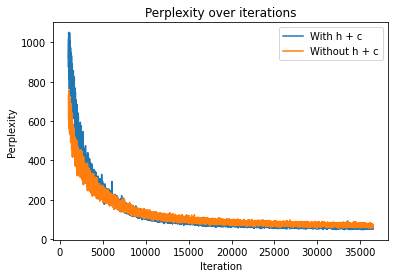

In [32]:
plt.plot(iter_[start:n], per_1[start:n])
plt.plot(iter_[start:n], per_2[start:n])
plt.xlabel('Iteration')
plt.ylabel('Perplexity')
plt.legend(['With h & c', 'Without h & c'])
plt.title('Perplexity over iterations')
plt.savefig('perplexity.png')
plt.show()

# Evaluate Model

In [ ]:
# tokenizer.decode_batch(list(train_ids[0:config.BATCH_SIZE].cpu().numpy()))

In [ ]:
print(sample_sequence("in september 2010 , a teaser website"))

In [ ]:
import os
model_name_list = os.listdir('./models/')
print(model_name_list)

In [ ]:
model_name = model_name_list[0]

In [ ]:
# Load already saved model
model = Seq(config.VOCAB_SIZE, config.PARAM, device)
model.load_state_dict(torch.load('./models/'+model_name, map_location=torch.device("cpu"))) #"./models/saved_model_1", config.PATH_MODEL
model.eval()